In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Pull in the public session and evse tables and combine on evse_id.

### session table

`session_id` - PK - an identifier that is artificially generated to represent a unique charging session

`evse_id` - FK to the EVSE table, represents the EVSE where the session is being completed

`connector_id` - FK to connector table represents which unique port is being used

`start_datetime` - session start date and time

`end_datetime` - session charge end date and time

`total_duration` - the amount of time between start_datetime and end_datetime (in hours)

`charge_duration` - the amount of time that energy was provided from the EVSE to the vehicle (in hours)

`energy_kwh` - amount of energy provided (in kWh)

`charge_level` - records which level of charging is being used for that session (L2, DCFC)

`start_soc` - % of battery capacity  at the start of the session (only available for DCFC)

`end_soc` - % of battery capacity at the end of session (only available for DCFC)

`flag_id` - FK to PK id in flag table, denotes an error with the session (refer to flag table)

### evse table

`evse_id` - PK - an identifier that is artificially generated to represent a unique EVSE

`metro_area` - The metropolitan area that the particular EVSE resides in. Undesignated are areas either not in metropolitain areas or an area with too few EVSE for anonymization

`land_use` - Identifies whether the EVSE is in a Metro area, Non-Metro area, or the location is undesignated

`region` - This is the region of the US the EVSE is located in. These are the same divisions from the US Census

`num_ports` - the number of ports capable of simultaneous charging available at a EVSE

`charge_level` - rate of charging (L2, DCFC)

`venue` - Derived field of venue type

`pricing` - Information on charging. Can be Paid, Free, or Undesignated


In [3]:
sessions_df = pd.read_csv("../data/evwatts.public.session.csv")
evse_df = pd.read_csv("../data/evwatts.public.evse.csv")

In [4]:
combined_df = pd.merge(sessions_df, evse_df, on='evse_id')
combined_df.head()

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,Undesignated,Undesignated,Middle Atlantic,2,L2,Municipal Building,Undesignated
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2,L2,Medical or Educational Campus,Undesignated
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,"Rochester, NY Metro Area",Metro Area,Middle Atlantic,2,L2,Municipal Building,Undesignated
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2,L2,Municipal Building,Undesignated
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2,L2,Municipal Building,Undesignated


## Data Exploration with Flag ID

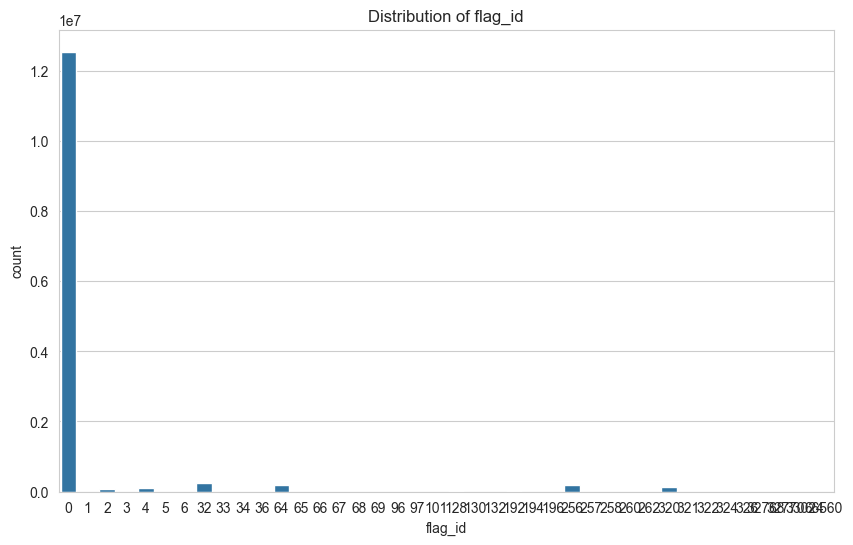

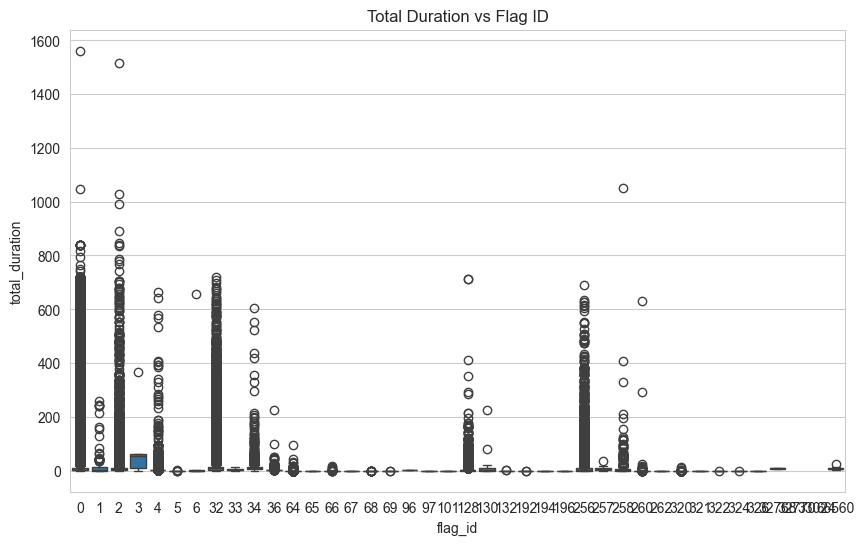

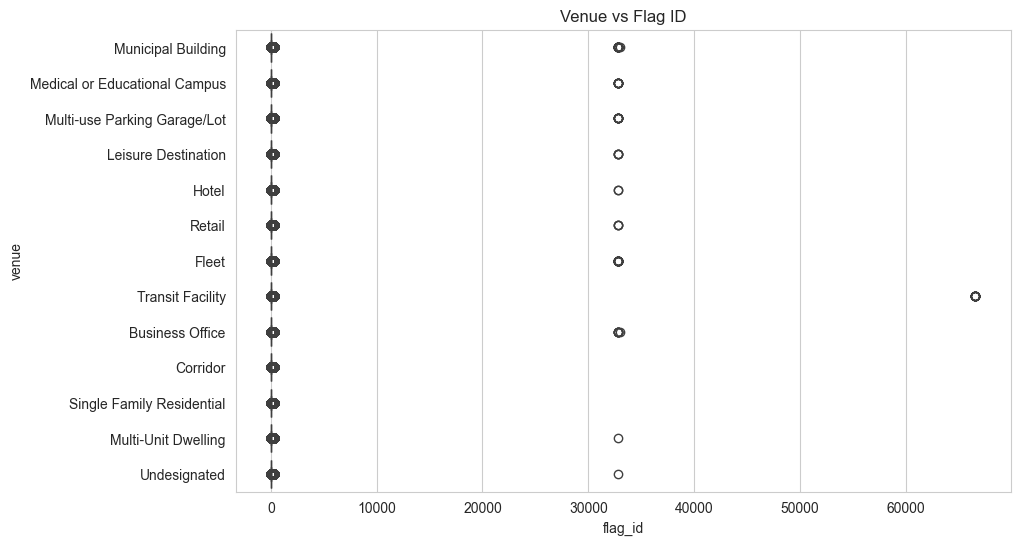

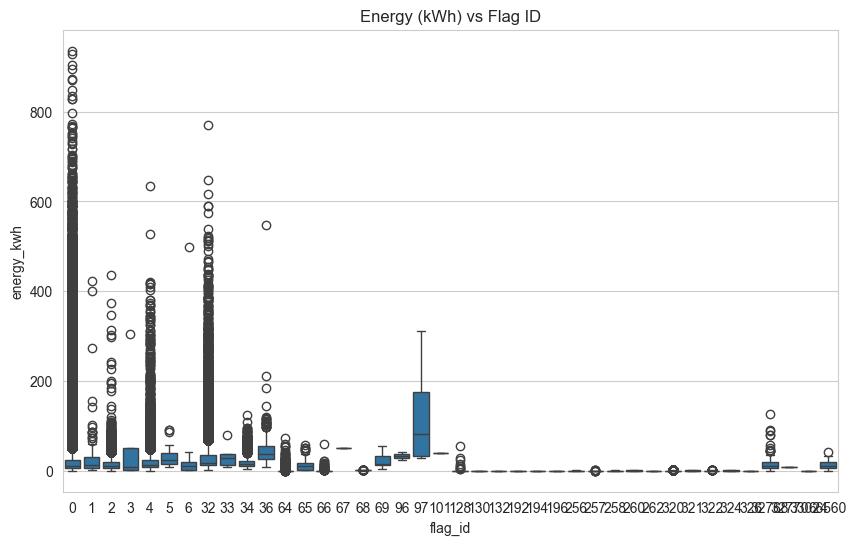

In [5]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of flag_id
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='flag_id')
plt.title('Distribution of flag_id')
plt.show()

# Plot the relationship between flag_id and total_duration
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='flag_id', y='total_duration')
plt.title('Total Duration vs Flag ID')
plt.show()

# Plot the relationship between flag_id and charge_duration
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='flag_id', y='venue')
plt.title('Venue vs Flag ID')
plt.show()

# Plot the relationship between flag_id and energy_kwh
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='flag_id', y='energy_kwh')
plt.title('Energy (kWh) vs Flag ID')
plt.show()

## Flag ID by Metro Area

In [6]:
metro_area_coords = {
    'Undesignated': (None, None),
    'Rochester, NY Metro Area': (43.1566, -77.6088),
    'Albany-Schenectady-Troy, NY Metro Area': (42.6526, -73.7562),
    'Dallas-Fort Worth-Arlington, TX Metro Area': (32.7767, -96.7970),
    'Denver-Aurora-Lakewood, CO Metro Area': (39.7392, -104.9903),
    'Boulder, CO Metro Area': (40.0150, -105.2705),
    'Los Angeles-Long Beach-Anaheim, CA Metro Area': (34.0522, -118.2437),
    'Des Moines-West Des Moines, IA Metro Area': (41.5868, -93.6250),
    'Boston-Cambridge-Newton, MA-NH Metro Area': (42.3601, -71.0589),
    'Providence-Warwick, RI-MA Metro Area': (41.8240, -71.4128),
    'New York-Newark-Jersey City, NY-NJ-PA Metro Area': (40.7128, -74.0060),
    'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area': (39.9526, -75.1652),
    'Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area': (38.9072, -77.0369),
    'Baltimore-Columbia-Towson, MD Metro Area': (39.2904, -76.6122),
    'Detroit-Warren-Dearborn, MI Metro Area': (42.3314, -83.0458),
    'Austin-Round Rock-Georgetown, TX Metro Area': (30.2672, -97.7431),
    'Burlington-South Burlington, VT Metro Area': (44.4759, -73.2121),
    'Chicago-Naperville-Elgin, IL-IN-WI Metro Area': (41.8781, -87.6298),
    'Salem, OR Metro Area': (44.9429, -123.0351),
    'Seattle-Tacoma-Bellevue, WA Metro Area': (47.6062, -122.3321),
    'Las Vegas-Henderson-Paradise, NV Metro Area': (36.1699, -115.1398),
    'Phoenix-Mesa-Chandler, AZ Metro Area': (33.4484, -112.0740),
    'Miami-Fort Lauderdale-Pompano Beach, FL Metro Area': (25.7617, -80.1918),
    'Ann Arbor, MI Metro Area': (42.2808, -83.7430),
    'Kansas City, MO-KS Metro Area': (39.0997, -94.5786),
    'Grand Rapids-Kentwood, MI Metro Area': (42.9634, -85.6681),
    'Pittsburgh, PA Metro Area': (40.4406, -79.9959),
    'Portland-Vancouver-Hillsboro, OR-WA Metro Area': (45.5051, -122.6750),
    'Reno, NV Metro Area': (39.5296, -119.8138),
    'Worcester, MA-CT Metro Area': (42.2626, -71.8023)
}

In [7]:
# Aggregate data by metro_area
agg_df = combined_df.groupby('metro_area').agg(
  flag_id_0_count=pd.NamedAgg(column='flag_id', aggfunc=lambda x: (x == 0).sum()),
  flag_id_non_0_count=pd.NamedAgg(column='flag_id', aggfunc=lambda x: (x != 0).sum())
).reset_index()

# Map metro areas to coordinates
agg_df['latitude'] = agg_df['metro_area'].map(lambda x: metro_area_coords.get(x, (None, None))[0])
agg_df['longitude'] = agg_df['metro_area'].map(lambda x: metro_area_coords.get(x, (None, None))[1])

# Calculate the ratio of non-0 flag_id to 0 flag_id
agg_df['flag_id_ratio'] = round(agg_df['flag_id_non_0_count'] / agg_df['flag_id_0_count'], 2)

# Filter out the 'Undesignated' metro_area
agg_df = agg_df[agg_df['metro_area'] != 'Undesignated']

In [8]:
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, feature="states")

background = alt.Chart(states).mark_geoshape(
    fill="#e3faff",
    stroke="#bbbcbd"
).properties(
    width=750,
    height=500
).project("albersUsa")

points_flag_id_0 = alt.Chart(agg_df).mark_circle().encode(
    latitude="latitude:Q",
    longitude="longitude:Q",
    size=alt.Size("flag_id_0_count:Q").legend(None).scale(range=[0, 2000]),
    color=alt.value("#51fafc"),
    tooltip=["metro_area:N", "flag_id_0_count:Q", alt.Tooltip("flag_id_ratio:Q", format=".0%")]
)

points_flag_id_non_0 = alt.Chart(agg_df).mark_circle().encode(
    latitude="latitude:Q",
    longitude="longitude:Q",
    size=alt.Size("flag_id_non_0_count:Q").legend(None).scale(range=[0, 2000]),
    color=alt.value("#5f51fc"),
    tooltip=["metro_area:N", "flag_id_non_0_count:Q", alt.Tooltip("flag_id_ratio:Q", format=".0%")]
)

legend = alt.Chart(pd.DataFrame({
    'Color': ['#51fafc', '#5f51fc'],
    'Label': ['No Faults (flag_id == 0)', 'Faulted (flag_id != 0)']
})).mark_point().encode(
    y=alt.Y('Label:N', axis=alt.Axis(title='')),
    color=alt.Color('Color:N', scale=None)
)

(background + points_flag_id_0 + points_flag_id_non_0 | legend).configure_view(stroke=None).properties(
    title="Faulted vs Non-Faulted Charging Sessions by Metro Area"
)

alt.HConcatChart(...)

Notes:

Remove end_soc - start_soc which are negative
